# This notebook is for Analyzing Enron Email Dataset

## Tasks to Do

1. Select emails base on keywords 
    1. Load, Clean & Parse Emails to get started
    2. Select emails based on keywords
2. Time series analysis of the emails
    1. Parse string to Datetime object for doing time series analysis
    2. Plot time series
3. Email Clustering
    1. Rremoving stopwords and vectorize the content
    2. Run KMeans on the Data
    3. Find important keywords from for each clusters
    4. Find topics from the text (??)
4. Sentiment Analysis
    1. Do Sentiment analysis on the email texts
    2. plot sentiments 


#### Importing modules

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans

from utils import top_mean_feats, top_feats_per_cluster, plot_tfidf_classfeats_h
plt.rcParams["figure.figsize"] = (20,8) #Setting global parameters for plots


#### Reading Data from the directory

In [2]:
df = pd.read_csv('enron_email/emails.csv')


#### Select Emails those have the word project

In [3]:
def mark_words(row):
    if 'project' in row['message']:
        return 'has project word'
    return 'no project word'

df['project_status'] = df.apply(mark_words, axis = 1)

In [4]:
project_df = df[df['project_status'] == 'has project word']

#### A simple email data

In [5]:
project_df['message'].tolist()[5]

"Message-ID: <31434120.1075855688116.JavaMail.evans@thyme>\nDate: Wed, 20 Sep 2000 06:34:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: cbpres@austin.rr.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: cbpres@austin.rr.com\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\nGeorge,\n\n Below is a list of questions that Keith and I had regarding the Westgate \nproject:\n\n Ownership Structure\n\n What will be the ownership structure? Limited partnership? General partner?\n\n What are all the legal entities that will be involved and in what \ncapacity(regarding ownership and \n liabilities)?\n\n Who owns the land? improvements?\n\n Who holds the various loans?\n\n Is the land collateral?\n\n Investment\n \n What happens to initial investment?\n\n Is it used to purchase land for cash?Secure future loans?\n \n Why is the 

#### Parsing Emails for extracting important information. For example( Sender, Reciever, Subject, Body, Date, etc.)

In [6]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'subject', 'date', 'x-from', 'x-to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            val = val.replace('.', '. ')
            if key in keys_to_extract:
                email[key] = val
    return email
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    bodies = []
    tos = []
    froms = []
    subjects = []
    dates = []
    xfroms = []
    xtos = []
    for email in emails:
        froms.append(email['from'])
        tos.append(email.get('to', None))
        bodies.append(email['body'])
        subjects.append(email.get('subject', None))
        dates.append(email.get('date', None))
        xfroms.append(email.get('x-from', None))
        xtos.append(email.get('x-to', None))
    return {
        'body': bodies, 
        'to': tos, 
        'from_': froms,
        'subject': subjects,
        'date': dates,
        'xfroms': xfroms,
        'xtos': xtos
    }

In [7]:
project_email_df = pd.DataFrame(parse_into_emails(project_df.message))
print('Total Emails containg word project ', len(project_email_df))

Total Emails containg word project  27187


#### Clean Duplicate Body Emails

In [8]:
project_email_df = project_email_df.drop_duplicates('body',keep = 'first')
print('Total Unique Emails containging word project')

Total Unique Emails containging word project


#### Sample of a parsed Email

In [9]:
project_email_df.loc[0]

body       ---------------------- Forwarded by Phillip K ...
to                            Richard Burchfield/HOU/ECT@ECT
from_                              phillip. allen@enron. com
subject                               Consolidated positions
date                                      Mon, 9 Oct 2000 07
xfroms                                       Phillip K Allen
xtos                                             Keith Holst
Name: 0, dtype: object

In [10]:
project_email_df

,body,to,from_,subject,date,xfroms,xtos
0,---------------------- Forwarded by Phillip K ...,Richard Burchfield/HOU/ECT@ECT,phillip. allen@enron. com,Consolidated positions,"Mon, 9 Oct 2000 07",Phillip K Allen,Keith Holst
2,---------------------- Forwarded by Phillip K ...,"""Phillip Allen"" <pallen@enron. com>",phillip. allen@enron. com,Westgate,"Tue, 3 Oct 2000 09",Phillip K Allen,pallen70@hotmail. com
3,---------------------- Forwarded by Phillip K ...,"""Phillip Allen"" <pallen@enron. com>",phillip. allen@enron. com,Investment Structure,"Tue, 26 Sep 2000 09",Phillip K Allen,kholst@enron. com
5,"George,Below is a list of questions that Keith...",cbpres@austin. rr. com,phillip. allen@enron. com,,"Wed, 20 Sep 2000 06",Phillip K Allen,cbpres@austin. rr. com
6,---------------------- Forwarded by Phillip K ...,"""Phillip Allen"" <pallen@enron. com>",phillip. allen@enron. com,Westgate Proforma-Phillip Allen. xls,"Tue, 19 Sep 2000 09",Phillip K Allen,pallen70@hotmail. com
...,...,...,...,...,...,...,...
27182,I am sure that John Lavorato will want to see ...,cooper. richey@enron. com,john. zufferli@enron. com,presentation for lavo,"Mon, 6 Aug 2001 11","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Richey, Cooper </O=ENRON/OU=NA/CN=RECIPIENTS/C..."
27183,-----Original Message-----The implementation o...,denis. martin@airliquide. com; pbartsch@utilic...,Barry Rushford <barry. rushford@powerpool. ab....,Automated Dispatch Messaging from the Power Po...,"Fri, 29 Jun 2001 08","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Taylor, Michael J. </O=ENRON/OU=NA/CN=RECIPIE..."
27184,an\td 2003 -200X Meeting-----Original Message-...,=09A. A. da Silva (E-mail); A. L. McLarty ...,"=09""Nering, Debbie"" <debbie. nering@eal. ab. c...",=09ESBI Alberta Ltd. - Stakeholder Developmen...,"Mon, 25 Jun 2001 07","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Messenger, John P. </O=ENRON/OU=NA/CN=RECIPIE..."
27185,I hope stock goes to $35 so I can buy it at re...,John Zufferli (E-mail),"""Meyerhoeffer, Dale"" <DMeyerhoeffer@mlp. com>@...",Bleeding,"Wed, 20 Jun 2001 14","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","'""Meyerhoeffer, Dale"" <DMeyerhoeffer@mlp. com>..."


#### Checked Important Email Senders

In [11]:
largest_emails = project_email_df.groupby('from_').size().nlargest(5)

<AxesSubplot:xlabel='from_'>

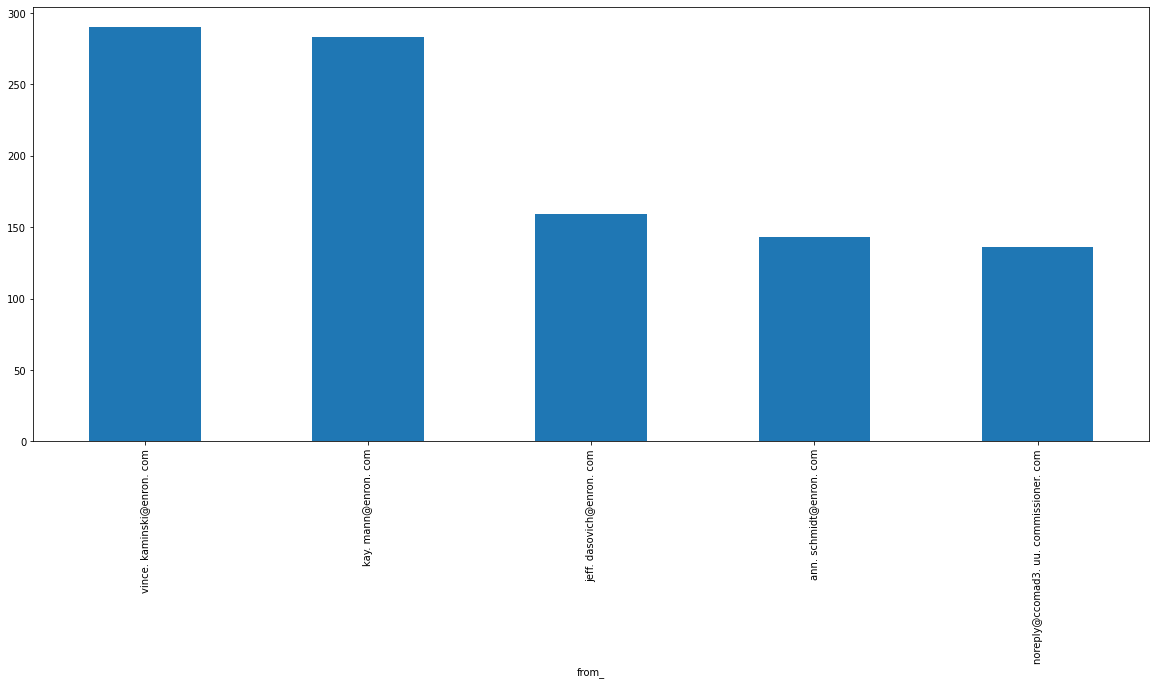

In [12]:
largest_emails.plot.bar()

In [13]:
tos = project_email_df['to'].tolist()

to_freq = {}
for to in tos:
    to_freq[to] = to_freq.get(to, 0) + 1


In [14]:
for key, val in largest_emails.to_dict().items():
    print(to_freq.get(key, 0))

34
47
73
15
0


#### Parsing Date String to (yyyy-mm-dd hh:mm:ss)

In [15]:
# Sample for parsing
datetime_object = datetime.strptime('Thu, 31 Aug 2000 05', '%a, %d %b %Y %H')
print(datetime_object)

2000-08-31 05:00:00


In [16]:
def parse_date(row):
    date_str = row['date']
    try:
        datetime_object = datetime.strptime(date_str, '%a, %d %b %Y %H')
    except:
        return None
    return datetime_object

In [17]:
#Parsing dates for all emails
project_email_df['date_converted'] = project_email_df.apply(parse_date, axis = 1)

In [18]:
#Ignore emails that failed in date conversion
project_email_df.dropna(inplace =True)

In [19]:
#Sample of Date Conversion
project_email_df['date_converted']

0       2000-10-09 07:00:00
2       2000-10-03 09:00:00
3       2000-09-26 09:00:00
5       2000-09-20 06:00:00
6       2000-09-19 09:00:00
                ...        
27182   2001-08-06 11:00:00
27183   2001-06-29 08:00:00
27184   2001-06-25 07:00:00
27185   2001-06-20 14:00:00
27186   2001-12-11 09:00:00
Name: date_converted, Length: 11368, dtype: datetime64[ns]

<AxesSubplot:xlabel='date_converted'>

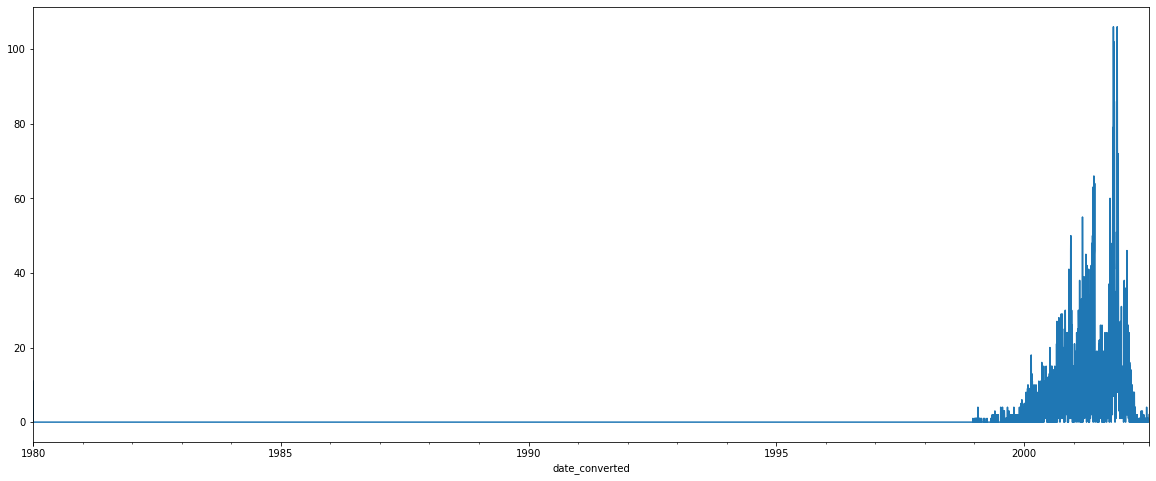

In [20]:
# Email Timelines (change the parameter in the last line to get timeline datewise (D), monthwise (M), yearwise (Y))
plt.rcParams["figure.figsize"] = (20,8)
project_email_df = project_email_df.set_index('date_converted') 
project_email_df.sort_index(inplace = True)
project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

In [21]:
# Select Emails after the year 2000 to get a nice plot
project_email_df['parsed_date'] = project_email_df.index
mask = project_email_df['parsed_date'] > '2000-01-01'
project_email_df = project_email_df.loc[mask]

<AxesSubplot:xlabel='date_converted'>

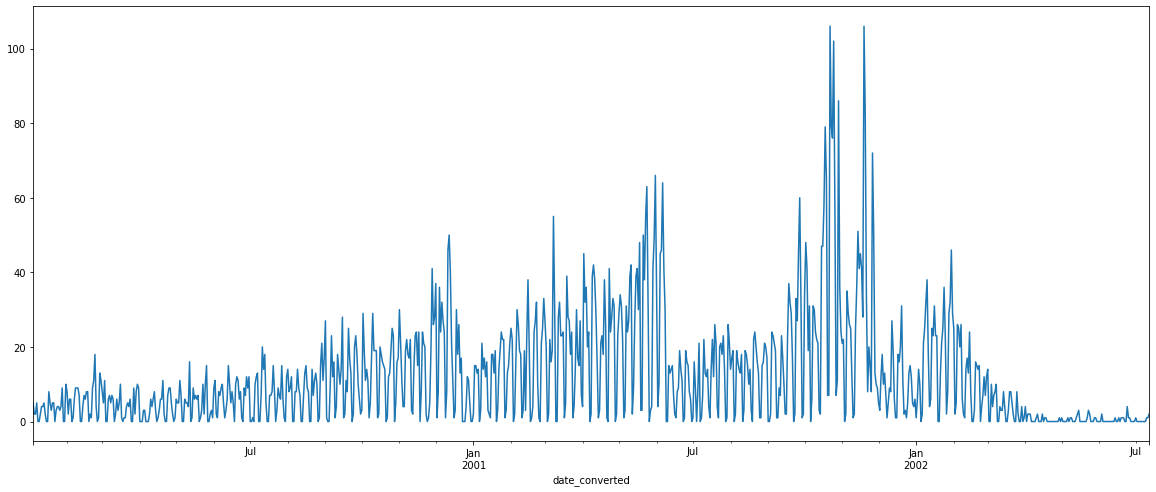

In [22]:

project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

## Cluster Emails 

In [23]:
# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(project_email_df.body)
features = vect.get_feature_names()

In [24]:
n_clusters = 
batch_size = 500
clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
clf.fit(X)
labels = clf.fit_predict(X)


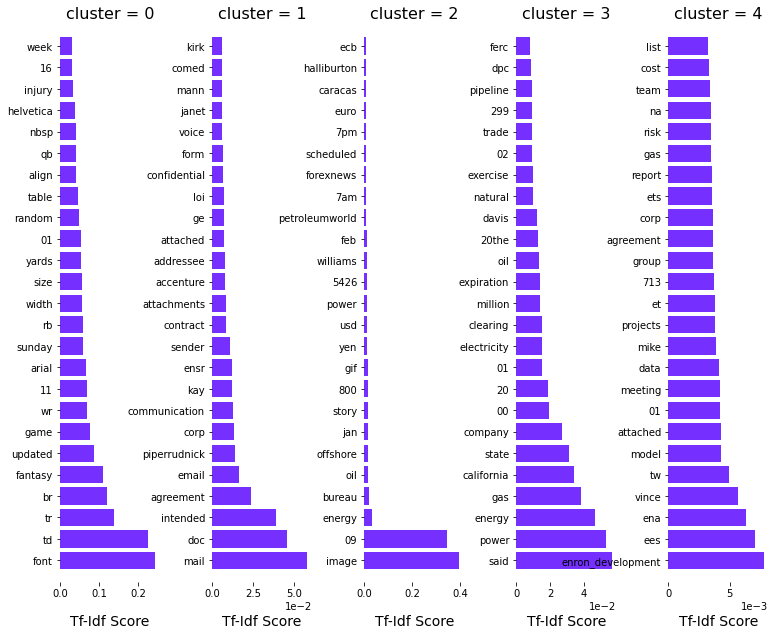

In [25]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


### Sentiment Analysis

In [26]:
sentiments = []
bodies = []
dates = []
for index, row in project_email_df.iterrows():
    body = row['body']
    bodies.append(body)
    opinion = TextBlob(body)
    pol, sent = opinion.sentiment
    if sent < 0.7:
        continue
    sentiments.append(sent)
    dates.append(row['parsed_date'])

Text(0, 0.5, 'Sentiment')

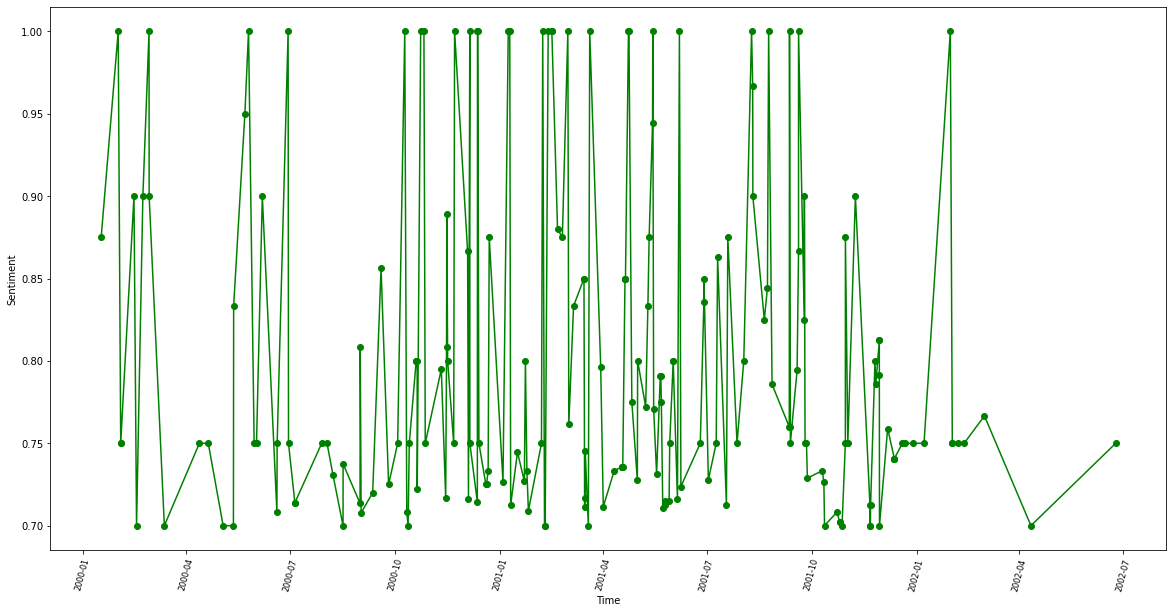

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.plot(dates, sentiments, marker='o', color = 'green' )

plt.xlabel('Time')
plt.ylabel('Sentiment')

In [28]:
count = 0
for sentiment, body, date in zip(sentiments, bodies, dates):
    if sentiment > 0.95:
        print(body)
        print('\n' * 2)
        count += 1
        if count == 10:
            break
        
        

Candace,Sorry for the delay. I shall edit the job description and forward it to youlater today.VinceCandace Womack<rvanraven@ix.netcom.com>, Margaret Daffin/HOU/ECT@ECT, JaneAllen/HOU/ECT@ECTVince - Will you please review the following job description which Tindall &Foster has prepared, and edit it as needed for Vincent Tang's position?We need this job description in order to proceed with the other stepsnecessary in obtaining Vincent's green card.Please feel free to call me if you have any questions regarding this.  Thanks.Candacex30651---------------------- Forwarded by Candace Womack/HOU/ECT on 01/04/2000I still do not have a job description for Vincent's position.  MaybeEnron does not have one?Candace, here is a sample job description.  Please check with Vincent'ssupervisor on modifying this for the job description.  This was my bestguess, but I may be way off... If so, we have many other genericexamples to use instead.  Just let me know.Operations Research; Research Analyst)Project

In [29]:
print(len(bodies), len(set(bodies)))

11152 11152
